# Dataset "Rides on the MVG bike"

https://opendata.muenchen.de/dataset/fahrten-mit-dem-mvg-rad

This data record includes anonymized raw data from trips with MVG bikes. The following data can be downloaded, viewed and evaluated for each bike rental:

* Start date and time of the loan
* End date and time of the loan
* Loan start coordinates
* Coordinates rental end
* Rental start station-based or free-floating
* Possibly station name
* Rental end station based or free floating
* Possibly station name

The data is always provided for an entire year. The upload takes place with a certain time lag of about 5-6 months, so that the data is available in May or June of the following year.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("MVG_Rad_Fahrten_2021.csv", delimiter=";")

# remove spaces from column names
df.columns = df.columns.str.replace(" ", "")
df["STARTTIME"] = pd.to_datetime(df["STARTTIME"],format="%Y-%m-%d %H:%M")
df["ENDTIME"] = pd.to_datetime(df["ENDTIME"],format="%Y-%m-%d %H:%M")

# we keep the starttime column so we can later use it in apply
df["INDEX"] = df["STARTTIME"]
df.set_index("INDEX", inplace=True)
df

,Row,STARTTIME,ENDTIME,STARTLAT,STARTLON,ENDLAT,ENDLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,RETURN_IS_STATION,RETURN_STATION_NAME
INDEX,,,,,,,,,,,
2021-01-01 01:01:00,1,2021-01-01 01:01:00,2021-01-01 01:12:00,48.12580,11.64784,48.12948,11.62539,1,Kreillerstraße,0,
2021-01-01 01:19:00,2,2021-01-01 01:19:00,2021-01-01 01:59:00,48.12919,11.62583,48.14853,11.53142,0,,0,
2021-01-01 01:48:00,3,2021-01-01 01:48:00,2021-01-01 02:01:00,48.08189,11.63264,48.07975,11.61032,1,Universitätsstraße Neubiberg,1,Fasanenpark Ost Neubiberg
2021-01-01 01:48:00,4,2021-01-01 01:48:00,2021-01-01 02:00:00,48.08189,11.63264,48.07975,11.61032,1,Universitätsstraße Neubiberg,1,Fasanenpark Ost Neubiberg
2021-01-01 03:26:00,5,2021-01-01 03:26:00,2021-01-01 03:39:00,48.11587,11.62543,48.10900,11.65240,0,,0,
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:46:00,619569,2021-12-31 23:46:00,2021-12-31 23:51:00,48.16472,11.51546,48.15935,11.52529,0,,0,
2021-12-31 23:48:00,619570,2021-12-31 23:48:00,2021-12-31 23:59:00,48.12063,11.61786,48.11920,11.63052,1,Innsbrucker Ring,1,Michaelibad
2021-12-31 23:50:00,619571,2021-12-31 23:50:00,2022-01-01 00:00:00,48.14251,11.57739,48.13658,11.59283,0,,0,


## Data Preparation

### Calculating the distance

The distance between two points on earth can be calculated using the `geopy` library.

In [3]:
# Calculate distance between rental and return
from geopy.distance import geodesic

def distance(row):
    row_dict = row.to_dict()
    start = (row_dict["STARTLAT"], row_dict["STARTLON"])
    end = (row_dict["ENDLAT"], row_dict["ENDLON"])
    return int(geodesic(start, end).meters)

df["DISTANCE_METERS"] = df.apply(distance, axis=1)
df['DISTANCE_KM'] = df['DISTANCE_METERS'] / 1000

## Answers to the questions

### How long do people usually rent these bikes?

First we need to calculate the duration of the trips from the start and end timestamps.

In [4]:
# Calculate duration of ride
def duration(row):
    row_dict = row.to_dict()
    delta_minutes = (row_dict["ENDTIME"] - row_dict["STARTTIME"]).total_seconds() / 60.0
    return delta_minutes

df["DURATION_MINUTES"] = df.apply(duration, axis=1)

Then we create a histogram as table and as graph to get the answer to our question.

In [5]:
# Define the bin edges and labels
bin_edges = [0, 2, 5, 10, 15, 30, 60, 240, 1440, np.inf]
bin_labels = ['0-2 min','2-5 min', '5-10 min', '10-15 min', '15-30 min', '30-60 min', '1-4h', '4h-1day', '1day+']

# Create a new column with the binned values
df['DURATION_MINUTES_BINNED'] = pd.cut(df['DURATION_MINUTES'], bins=bin_edges, labels=bin_labels)
duration_value_counts = df['DURATION_MINUTES_BINNED'].value_counts()

# Convert the value counts to a dataframe and sort by index
duration_histogram_df = pd.DataFrame({'Count': duration_value_counts}).sort_index()
print(duration_histogram_df)

            Count
0-2 min     14871
2-5 min     73565
5-10 min   161799
10-15 min  124063
15-30 min  159822
30-60 min   52697
1-4h        23348
4h-1day      6602
1day+        1604


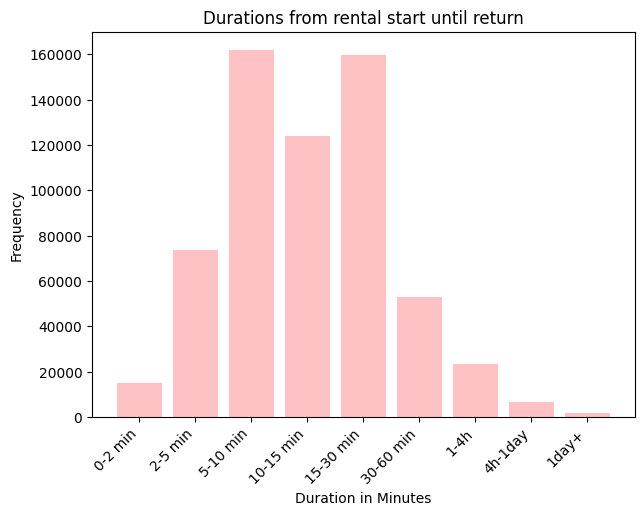

In [6]:
# Create the bar chart using Matplotlib
plt.figure(figsize=(7,5))
plt.bar(duration_histogram_df.index, duration_histogram_df['Count'], color='#FFC2C4')

# Set the title and axis labels
plt.title('Durations from rental start until return')
plt.xlabel('Duration in Minutes')
plt.ylabel('Frequency')

# Set the x-axis tick labels to the bin labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plot = plt.plot()

#### Answer

So the answer to the question "How long do people usually rent these bikes?" is that most people rent the bikes from **5-30 Minutes**. I am a bit surprised about the rentals under 5 minutes and guess these are issues when renting the bikes as it probably doesn't make sense to rent a bike for this duration.

### How far do they travel with them?

Again we create a histogram as table and as graph to get the answer to our question.

In [7]:
# Define the bin edges and labels
bin_edges = [0, 10, 20, 30, 40, 50, 75, 150, 300, np.inf]
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-75', '75-150', '150-300', '300+']

# Create a new column with the binned values
df['binned'] = pd.cut(df['DISTANCE_KM'], bins=bin_edges, labels=bin_labels)
value_counts = df['binned'].value_counts()

# Convert the value counts to a dataframe and sort by index
histogram_df = pd.DataFrame({'Count': value_counts}).sort_index()

print(histogram_df)

          Count
0-10     586125
10-20      3200
20-30        81
30-40       250
40-50        25
50-75         4
75-150       10
150-300       9
300+      13308


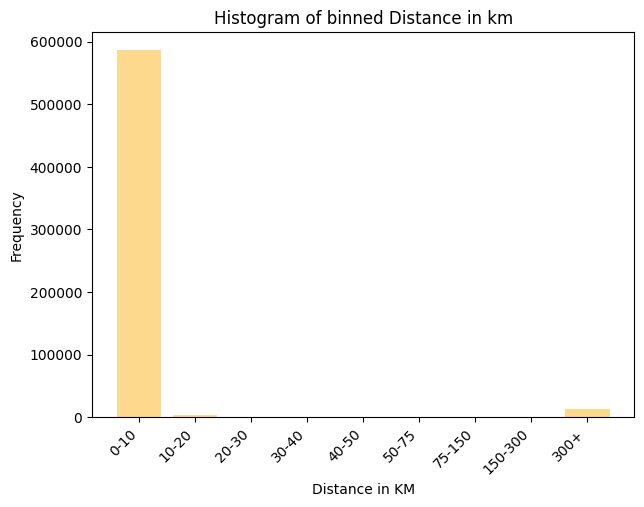

In [8]:
# Create the bar chart using Matplotlib
plt.figure(figsize=(7,5))
plt.bar(histogram_df.index, histogram_df['Count'], color='#FDD98D')

# Set the title and axis labels
plt.title('Histogram of binned Distance in km')
plt.xlabel('Distance in KM')
plt.ylabel('Frequency')

# Set the x-axis tick labels to the bin labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plot = plt.plot()

#### Answer (First attempt)

So the answer to the question "How far do they travel with them?" is that most people travel less than **10km** with them.

But then we see that there is a high number of people going over 300km with the MVG bikes which seems to be highly unlikely.

Also we can't account for people who take a bike, but then put the bike near where they took it. The distance between start and end is small, but they could have biked a longer distance.

#### Cleanup for second attempt

So for our second attempt we want to sanitize the data a bit more. We can do this by adding the speed to the dataframe.

In [9]:
# Calculate speed of ride

def speed(row):
    row_dict = row.to_dict()
    per_hour = (row_dict["DURATION_MINUTES"] / 60.0)
    if per_hour > 0:
        return (row_dict["DISTANCE_METERS"] / 1000.0) / per_hour
    else:
        return 0

df["SPEED"] = df.apply(speed, axis=1)

Now we just take the data from 5 - 30 km/h, so we get people who probably were constantly biking and haven't returned the bike near the start destination (they would have a very low speed than in this calculation).

In [10]:
df_valid_speed = df.query("SPEED > 4 and SPEED < 31").copy()

In [11]:
# Define the bin edges and labels
bin_edges = [0, 10, 20, 30, 40, 50, 75, 150, 300, np.inf]
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-75', '75-150', '150-300', '300+']

# Create a new column with the binned values
df_valid_speed['DISTANCE_SPEED_CORRECTED_BINNED'] = pd.cut(df_valid_speed['DISTANCE_KM'], bins=bin_edges, labels=bin_labels)
value_counts = df_valid_speed['DISTANCE_SPEED_CORRECTED_BINNED'].value_counts()

# Convert the value counts to a dataframe and sort by index
histogram_df = pd.DataFrame({'Count': value_counts}).sort_index()

print(histogram_df)

          Count
0-10     505222
10-20      2375
20-30        44
30-40        21
40-50         1
50-75         0
75-150        0
150-300       0
300+         41


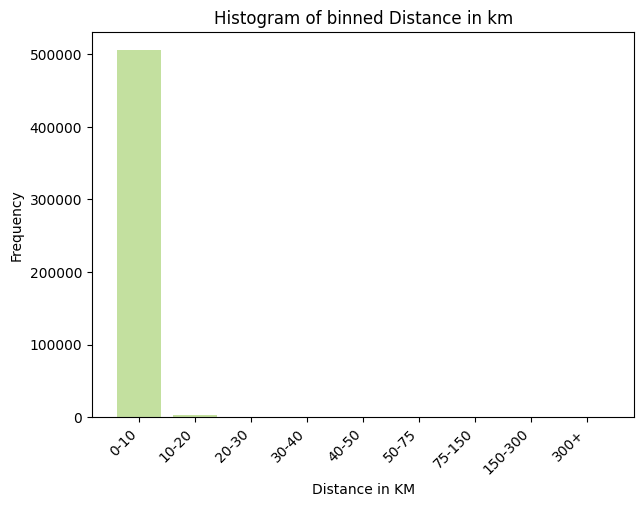

In [12]:
# Create the bar chart using Matplotlib
plt.figure(figsize=(7,5))
plt.bar(histogram_df.index, histogram_df['Count'], color='#C3E09F')

# Set the title and axis labels
plt.title('Histogram of binned Distance in km')
plt.xlabel('Distance in KM')
plt.ylabel('Frequency')

# Set the x-axis tick labels to the bin labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plot = plt.plot()

#### Answer (second attempt)
So the answer to the question “How far do they travel with them?” is still that most people travel less than 10km with them.

The number of people going over 300km has reduced (filtered out). As a future task it would be interesting to analyze these high distance trips and find out if these are real or something went wrong.

### Do people often use them complementary to the other public transport?

Check if the start or end of a rental is a public transport station.

In [13]:
total_number_of_rentals = df['STARTTIME'].count()
total_number_of_rentals

619573

In [14]:
return_is_station = df.query("(RENTAL_IS_STATION == 1) or (RETURN_IS_STATION == 1)")['STARTTIME'].count()
return_is_station

259594

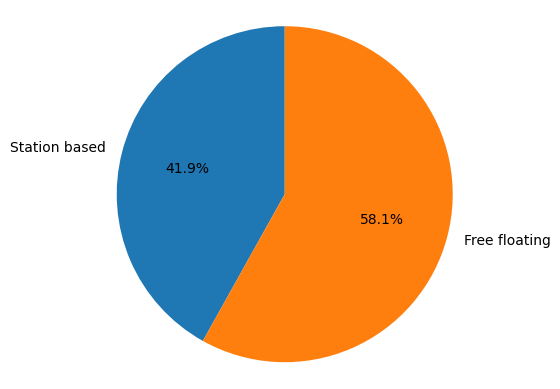

In [15]:
labels = ['Station based', 'Free floating']
sizes = [return_is_station, total_number_of_rentals - return_is_station]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Answer

The answer to the question "Do people often use them complementary to the other public transport?" is: Yes many people (about 42%) use the bikes to complement public transport, but also many (about 58%) people use the bikes independently from public transport.